<a href="https://www.kaggle.com/code/debasishbal/rnn-digit-recognition?scriptVersionId=190156044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import os
print(os.listdir("../input/digit-recognizer"))

['sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [4]:
train = pd.read_csv(r"../input/digit-recognizer/train.csv", dtype = np.float32)

targets_numpy = train.label.values
features_numpy = train.loc[:, train.columns != "label"]
features_numpy = features_numpy.values/255

features_train, features_test, targets_train, targets_test = train_test_split(features_numpy, 
                                                                              targets_numpy,
                                                                              test_size = 0.2,
                                                                              random_state=42)

In [5]:
# creating the tensors
featuresTrain = torch.from_numpy(features_train)
featuresTest = torch.from_numpy(features_test)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor)

In [6]:
batch_size = 100
n_iters = 10000
num_epochs = int(n_iters/(len(features_train) / batch_size))
num_epochs = int(num_epochs)
num_epochs

29

In [7]:
train = TensorDataset(featuresTrain, targetsTrain)
test = TensorDataset(featuresTest, targetsTest)

In [8]:
# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle=False)

In [9]:
train_loader

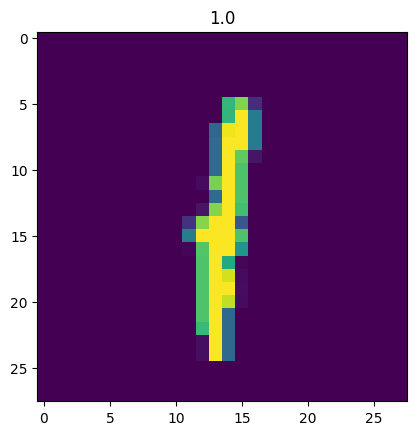

In [10]:
plt.imshow(features_numpy[12].reshape(28,28))
# plt.axis("off")
plt.title(str(targets_numpy[12]))
plt.show()

In [11]:
# creating the rnn model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        #no. of layer dimension
        self.layer_dim = layer_dim
        
        # RNN model
        self.rnn = nn.RNN(input_dim, 
                          hidden_dim, 
                          layer_dim, 
                          batch_first=True, 
                          nonlinearity='relu')
        
        # readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # init initial hidden stage with 0
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        # one time step
        out, hn = self.rnn(x,h0)
        out = self.fc(out[:, -1, :])
        
        return out
    
    
# crate RNN
input_dim = 28
hidden_dim = 100
layer_dim = 2
output_dim = 10

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# loss function
error = nn.CrossEntropyLoss()

# SGD optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        

In [12]:

# a = Variable(torch.zeros(1, 28, 1))
# print(a)


In [13]:
seq_dim = 28
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(train_loader):
        
        train = Variable(images.view(-1, seq_dim, input_dim))
        labels = Variable(labels)
        
        #clear gradient
        optimizer.zero_grad()
        
        # forward propagation
        outputs = model(train)
        
        
        # calaulate softmax and cross-entropy loss
        loss = error(outputs, labels)
        
        # calculating gradient 
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        count += 1
        
        
        if count%250 == 0:
            # calculate accuracy
            correct = 0
            total = 0
            
            # iterate through dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                #forward propagation
                outputs = model(images)
                
                #get prediction from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
                
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration 
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            if count%500 == 0:
                print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data, accuracy))
            
            

Iteration: 500 Loss: 1.2252421379089355 Accuracy: 52.154762268066406 %
Iteration: 1000 Loss: 0.5427364110946655 Accuracy: 75.08333587646484 %
Iteration: 1500 Loss: 0.2804001569747925 Accuracy: 90.48809814453125 %
Iteration: 2000 Loss: 0.28597474098205566 Accuracy: 91.11904907226562 %
Iteration: 2500 Loss: 0.1065920889377594 Accuracy: 95.14286041259766 %
Iteration: 3000 Loss: 0.11969257146120071 Accuracy: 95.67857360839844 %
Iteration: 3500 Loss: 0.3013138771057129 Accuracy: 95.08333587646484 %
Iteration: 4000 Loss: 0.05771790072321892 Accuracy: 97.08333587646484 %
Iteration: 4500 Loss: 0.23432137072086334 Accuracy: 96.6547622680664 %
Iteration: 5000 Loss: 0.05286412313580513 Accuracy: 97.11904907226562 %
Iteration: 5500 Loss: 0.4988611340522766 Accuracy: 87.45237731933594 %
Iteration: 6000 Loss: 0.03650353103876114 Accuracy: 97.39286041259766 %
Iteration: 6500 Loss: 0.08408838510513306 Accuracy: 97.45237731933594 %
Iteration: 7000 Loss: 0.07994749397039413 Accuracy: 97.07142639160156 %

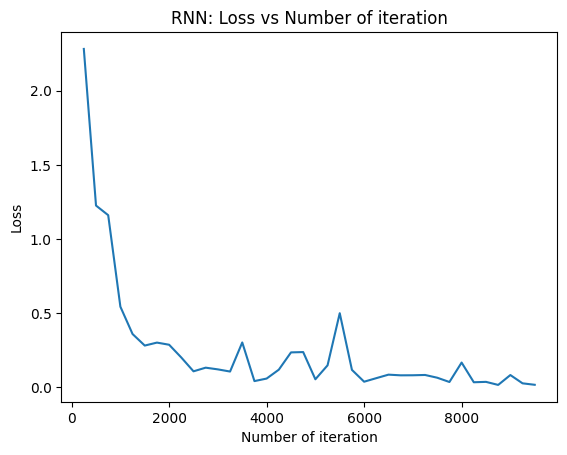

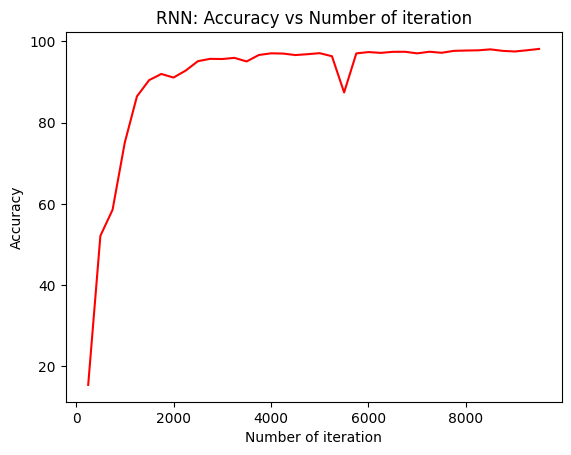

In [14]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()